# Clustering Headlines Based on Location

**Goal:** Generate a map with colored headline locations

**Approach:** We compare K-means clustering and DBSCAN clustering as ways to identify geographic clusters of headlines.

*Note: We have not actually tried to separate out the different diseases yet so we are not really seeing individual disease clusters.*

## Import Packages

Import packages

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

## Read in data 

Read in DataFrame saved from Part 2 that has headlines, location, and lat/long

In [2]:
df = pd.read_pickle("./data/headlines_with_location.pkl")
print(f"Read {df.shape[0]} headlines from saved data")

Read 650 headlines from saved data


In [3]:
df.head()

,Headline,City,Country,Latitude,Longitude,Country Code
0,Zika Outbreak Hits Miami,Miami,None,25.77427,-80.19366,US
1,Could Zika Reach New York City?,New York City,None,40.71427,-74.00597,US
2,First Case of Zika in Miami Beach,Miami Beach,None,25.79065,-80.13005,US
3,"Mystery Virus Spreads in Recife, Brazil",Recife,Brazil,-8.05389,-34.88111,BR
4,Dallas man comes down with case of Zika,Dallas,None,32.78306,-96.80667,US


## Clean up data

The clustering packages can't handle NaN values so we remove any headlines with NaN lat/long values 

In [4]:
#clean up the NaN from coordinates dataset so that the SK learn modeling will be happy
coords_clean = df[["Longitude", "Latitude"]].dropna()

In [6]:
print(f"After dropping NaN values, {np.shape(coords_clean)[0]} rows remaining")

After dropping NaN values, 610 rows remaining


# Map the headline locations

Generate a simple map to see the headline locations without any clustering

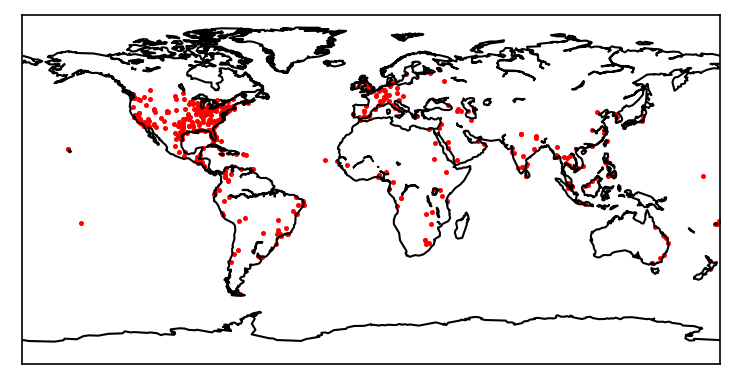

In [8]:
map = Basemap()
map.drawcoastlines()

x, y = map(coords_clean['Longitude'].to_list(),coords_clean['Latitude'].to_list())
map.scatter(x, y, marker='o', color = 'r', s = 2, latlon=True)

plt.rcParams['figure.dpi'] = 150 # default for me was 75
plt.show()

Look at one example point to check if it mapped properly

In [9]:
df[(df['Longitude'] < -148) & (df['Longitude'] > -152)]

,Headline,City,Country,Latitude,Longitude,Country Code
348,Lower Hospitalization in Papeete after Measles...,Papeete,None,-17.53733,-149.5665,PF


In [10]:
(df[['Latitude','Longitude']][df['Latitude'].isna() | df['Longitude'].isna()].dropna()).shape

(0, 2)


# Using K-means clustering to cluster the headline locations

Define a function that lets us easily generate a new map after re-running the clustering algorithm

In [11]:
def visualize(coords, colors, dpi = 200):
    '''visualize coords, a DataFrame with columns Longitude, Latitude, and Cluster '''
    map = Basemap()

    map.drawmapboundary()
    map.drawcoastlines()
    
    #translate clusters into colors
    colors = [colors[cluster] for cluster in coords['K-means'] ]
    
    x, y = map(coords['Longitude'].to_list(),coords['Latitude'].to_list())
    
    map.scatter(x, y, marker='o', c = colors, s = 2)
    
    plt.rcParams['figure.dpi'] = dpi # default for me was 75
    plt.show()

### Perform the K-means clustering

We input a number of clusters and then perform the K-means clustering. We also apply the Elbow Method to see how the clustering performs for different numbers of clusters.

### Define function for running the K-means clustering

In [12]:
def run_kmeans(coords, num_clusters):

    #Run the model
    cluster_model = KMeans(n_clusters = num_clusters)
    assignments = cluster_model.fit_predict(coords)
    
    coords['K-means'] = assignments
    
    return(coords)

### Generate an inertia plot

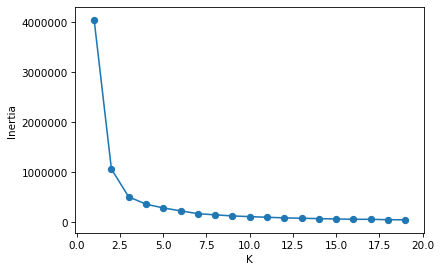

In [19]:
#Generate inertia data so that we can generate an inertia plot
k_values = range(1, 20)
inertia_values = [KMeans(k).fit(coords_clean).inertia_ for k in k_values]

plt.rcParams['figure.dpi'] = 75 # default for me was 75
plt.plot(k_values, inertia_values)
plt.scatter(k_values, inertia_values)
plt.xlabel("K")
plt.ylabel("Inertia")
plt.show()

From the generated plot we might say that 3 or 4 clusters would be enough to cluster the data reasonably well. To validate this let us map what the 3 clusters look like.
As we will see, the inertia is not that meaningful here.

### Map the 3 cluster result

We first generate a suitable color map

In [14]:
#Generate a color map from some default available color maps

from matplotlib.cm import get_cmap
name = "Set1"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors   # type: list
print(f"Generated {len(colors)} colors from colormap {name}")
map_colors = [colors[cluster] for cluster in range(len(colors))]

Generated 9 colors from colormap Set1


Then we run the K-means clustering for 3 clusters and produce a map of the result.

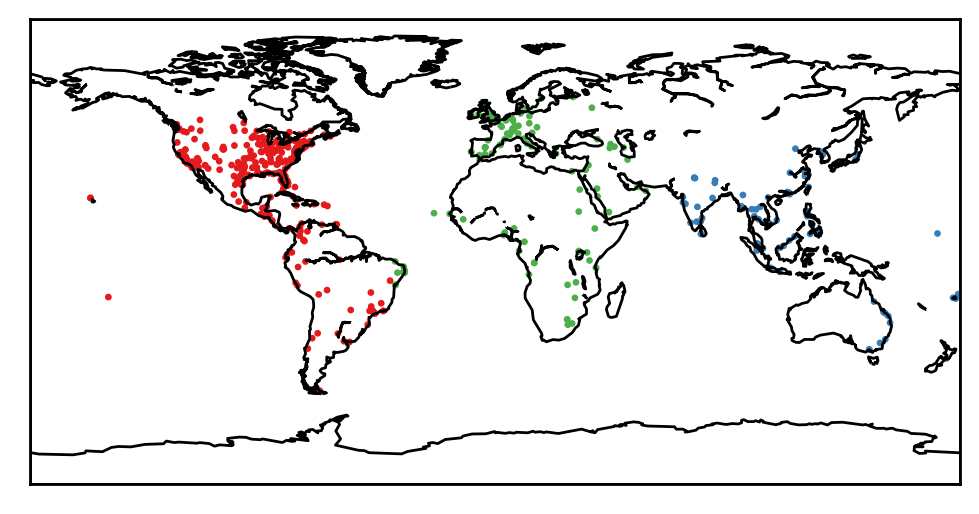

In [16]:
num_clusters = 3
coords_kmeans_3 = run_kmeans(coords_clean, num_clusters)
visualize(coords_kmeans_3, map_colors, dpi = 200)

**Analysis:** From the map can see that the clusters seem like they are too large and not really meaningful. Grouping Europe and Africa together, for example, doesn't really make sense.

Let's try a larger number of clusters to see what the result looks like.

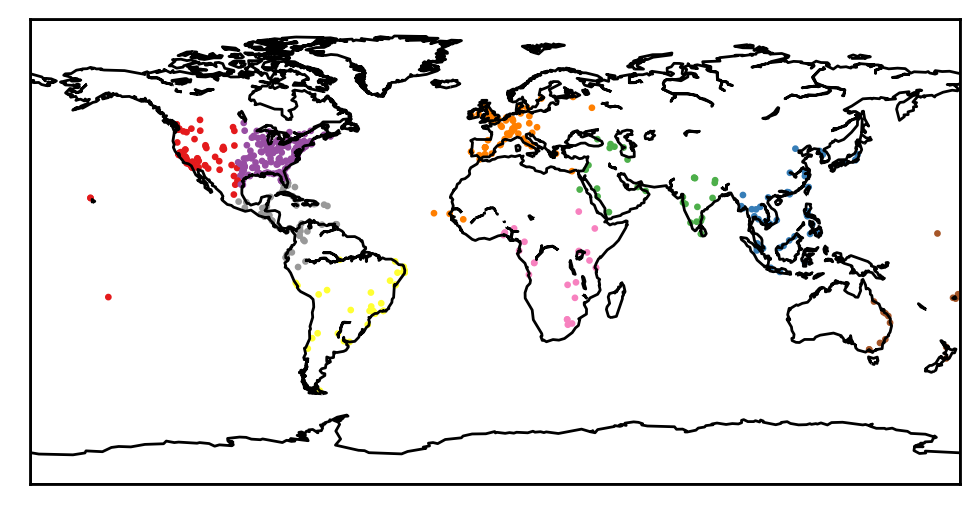

In [17]:
num_clusters = 9
coords_kmeans_9 = run_kmeans(coords_clean, num_clusters)
visualize(coords_kmeans_9, map_colors, dpi = 200)

**Analysis:** The 9 cluster grouping looks slightly better in that we capture the regions of the world at roughly the continent level. However, in the US we have an east/west split. Also, there are areas like the Middle East and India that probably don't make sense to be in a single cluster because they are actually very far from each other.

Let's try even more clusters!

In [31]:
num_clusters = 20
coords_kmeans_20 = run_kmeans(coords_clean, num_clusters)

In [34]:
#Generate a color map from some default available color maps

from matplotlib.cm import get_cmap
name1 = "tab20b"
default_color = 'w'
cmap1 = get_cmap(name1)  # type: matplotlib.colors.ListedColormap
colors = cmap1.colors  # type: list

print(f"Generated {len(colors)} colors from colormaps {name1}")
map_colors = [colors[cluster] if cluster != -1 else default_color for cluster in coords_kmeans_20['K-means']]

Generated 20 colors from colormaps tab20b


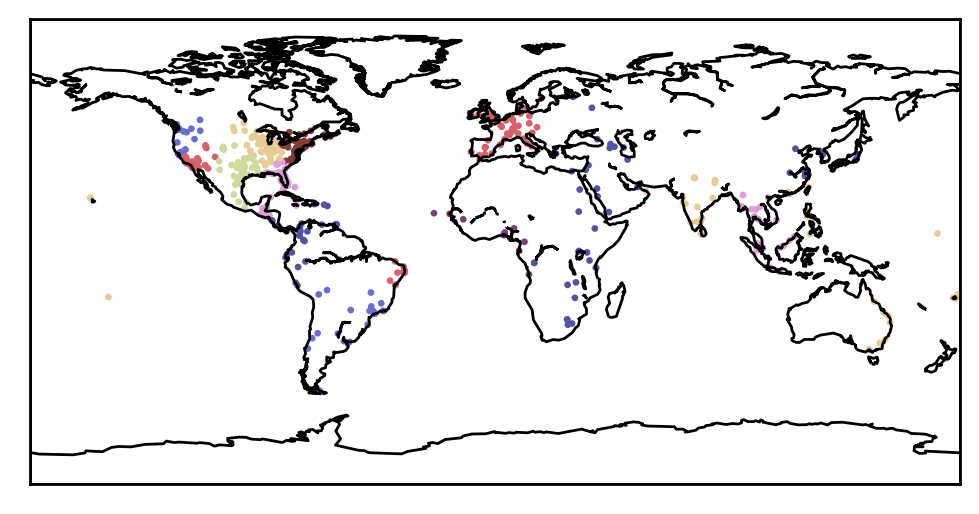

In [35]:
visualize(coords_kmeans_20, map_colors, dpi = 200)

**Analysis:** Trying even more clusters of 20 looks better in terms of identifying smaller groupings in the Eastern hemisphere, however, in the US where the diseases are denser it doesn't really feel like there ought to be so many clusters.

Let us try a different clustering approach instead.

# Using DBSCAN clustering to cluster the headline locations 

Cluster the data using using the DBSCAN method, which is density-based instead of mean-based.

First, we define a function to let us visualize the clusters.

In [36]:
def visualize_clusters(coords, color, dpi = 200):
    '''visualize coords, a DataFrame with columns Longitude, Latitude, and Cluster '''
    map = Basemap()

    map.shadedrelief()

    x, y = map(coords['Longitude'].to_list(),coords['Latitude'].to_list())
    map.scatter(x, y, marker='o', c = color, s = 1.5)
    
    plt.rcParams['figure.dpi'] = dpi # default for me was 75
    plt.show()

Next, we define a function that lets us run the DBSCAN model.

In [37]:
def run_dbscan(coords, epsilon = 5, min_points = 5):
    cluster_model = DBSCAN(eps=epsilon, min_samples=min_points)
    disease_clusters = cluster_model.fit_predict(coords)
    coords['DBSCAN'] = disease_clusters
    num_clusters = np.unique(disease_clusters)
    
    assert disease_clusters.shape[0] == coords.shape[0]
    
    return(coords, num_clusters)

In [39]:
coords_dbscan, num_clusters = run_dbscan(coords_clean, epsilon = 5.5, min_points = 3)
print(f"The clustering created {len(num_clusters)-1} clusters.")

The clustering created 33 clusters.


In [40]:
coords_dbscan.head()

,Longitude,Latitude,K-means,DBSCAN
0,-80.19366,25.77427,11,0
1,-74.00597,40.71427,7,0
2,-80.13005,25.79065,11,0
3,-34.88111,-8.05389,16,1
4,-96.80667,32.78306,1,2


Before plotting we need to generate a map with more colors

In [46]:
#Generate a color map from some default available color maps

from matplotlib.cm import get_cmap
name2 = "tab20b"
name1 = "tab20"
default_color = 'w'
cmap1 = get_cmap(name1)  # type: matplotlib.colors.ListedColormap
cmap2 = get_cmap(name2)
colors = cmap1.colors + cmap2.colors  # type: list
print(f"Generated {len(colors)} colors from colormaps {name1} and {name2}")
map_colors = [colors[cluster] if cluster != -1 else default_color for cluster in coords_dbscan['DBSCAN']]

Generated 40 colors from colormaps tab20 and tab20b


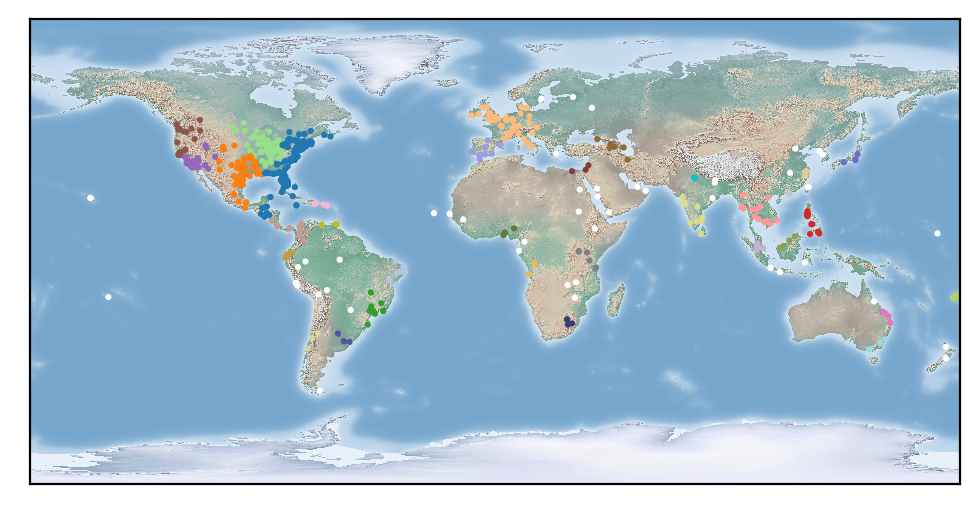

In [47]:
visualize_clusters(coords_dbscan, map_colors)

**Analysis:** This clustering feels more reasonable. We have large clusters in North America and Europe which do look geographically closer. The more numerous smaller clusters seems reasonable as isolated hot pockets. Finally, it also feels better that this algorithm is able to leave points as not belonging to any cluster (shown in white).  